In [1]:
package_paths = [r"C:\Users\benja\Documents\projects\goalscorers"]
import sys
for path in package_paths:
    sys.path.append(path)
import goalscorer_package.constants as c
import goalscorer_package.data_cleaning as dc
import goalscorer_package.modelling as m
import datetime as dt
import pandas as pd
import numpy as np
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import arviz as az
print(f"Running on Az v{az.__version__}")
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import glob
from statistics import mode
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 100)
pd.options.display.float_format = "{: ,.3f}".format
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
%config InlineBackend.figure_formats = ["retina"]

Running on PyMC v5.6.1
Running on Az v0.16.0


# Model description

$$
X_{i, k} \sim \text{Exponential}(\lambda=1 / \eta_{i, k}\tau_{i, k})  \\  
$$
$$
\eta_{i, k} = \text{exp}(\gamma + \Delta_i - \beta_{op} + P_{i, k})  \\  
$$
Constrain:  
$\sum_{op} \beta_{op} = 0$  

Where:  
$k$ - match  
$i$ - player_id  
  
$\gamma$ - home advantage  
$\Delta$ - player_id goal scoring propensity  
$\beta$ - team propensity to prevent goals - where average team is 0  
$P$ - player_id position prpoensity to score goals  

# Data

In [2]:
seasons = ["2020-2021"]
comp_ids = [9, 10, 11]

In [3]:
def data(seasons: list[str], comp_ids: list[int]) -> pd.DataFrame:
    seasons_leagues = dc.get_seasons_leagues_from_str(seasons, comp_ids)
    df = dc.load_seasons_leagues_files("summary", True, seasons_leagues)
    df = dc.split_positions(df)
    df = dc.position_to_generic_position(df)
    df = dc.add_frac_90(df)
    df = dc.add_home(df)
    df = dc.add_opp_team(df)
    df = dc.drop_gk(df)
    df = dc.drop_na_npxg(df)
    df = dc.drop_na_frac_90(df)
    df = dc.add_league(df)
    df["league_10"] = np.where((df.league == 10), 1, 0)
    return df

In [4]:
df = data(seasons, comp_ids)

In [5]:
df_model = df[["npxg", "player_id", "home", "opposition_team", "frac_90", "start", "position", "league", "league_10", "squad"]].copy()
df_model.head()

npxg player_id  home opposition_team  frac_90  start position  league  \
0  0.000  4047c976     1         Arsenal    0.689   True       FW       9   
1  0.000  3925dbd6     1         Arsenal    0.311  False       FW       9   
2  0.000  979b811d     1         Arsenal    1.000   True        W       9   
3  0.000  18b999f4     1         Arsenal    0.689   True        W       9   
4  0.000  6bb2c084     1         Arsenal    0.311  False        W       9   

   league_10   squad  
0          0  Fulham  
1          0  Fulham  
2          0  Fulham  
3          0  Fulham  
4          0  Fulham

# Model

## Priors

In [6]:
# Delta prior params
perc_sigma_increase = 0.0
dict_player_id_position_based_priors = {
    "FB": (-3.32, 0.86 * (1.0 + perc_sigma_increase/100.0)),
    "CB": (-2.75, 0.74 * (1.0 + perc_sigma_increase/100.0)),
    "WB": (-3.08, 0.73 * (1.0 + perc_sigma_increase/100.0)),
    "DM": (-3.13, 0.82 * (1.0 + perc_sigma_increase/100.0)),
    "CM": (-3.04, 0.86 * (1.0 + perc_sigma_increase/100.0)),
    "WM": (-2.55, 0.68 * (1.0 + perc_sigma_increase/100.0)),
    "AM": (-2.20, 0.56 * (1.0 + perc_sigma_increase/100.0)),
    "W": (-2.06, 0.50 * (1.0 + perc_sigma_increase/100.0)),
    "FW": (-1.70, 0.38 * (1.0 + perc_sigma_increase/100.0)),
}

In [7]:
dict_player_id_position_based_mins = {
    "FB": -4.02,
    "CB": -3.98,
    "WB": -4.68,
    "DM": -4.51,
    "CM": -4.52,
    "WM": -4.81,
    "AM": -4.99,
    "W": -4.96,
    "FW": -5.05,
}

In [8]:
# position prior params
perc_sigma_increase = 0.0
dict_position_priors = {
    "FB": (-0.59, 0.037 * (1.0 + perc_sigma_increase/100.0)),
    "CB": (-0.63, 0.043 * (1.0 + perc_sigma_increase/100.0)),
    "WB": (0.076, 0.044 * (1.0 + perc_sigma_increase/100.0)),
    "DM": (-0.098, 0.032 * (1.0 + perc_sigma_increase/100.0)),
    "CM": (-0.089, 0.027 * (1.0 + perc_sigma_increase/100.0)),
    "WM": (0.20, 0.025 * (1.0 + perc_sigma_increase/100.0)),
    "AM": (0.38, 0.036 * (1.0 + perc_sigma_increase/100.0)),
    "W": (0.30, 0.029 * (1.0 + perc_sigma_increase/100.0)),
    "FW": (0.45, 0.040 * (1.0 + perc_sigma_increase/100.0)),
}

In [9]:
player_id_codes, player_ids = pd.factorize(df_model.loc[:, "player_id"], sort=True)
team_codes, teams = pd.factorize(df_model.loc[:, "opposition_team"], sort=True)
position_codes, positions = pd.factorize(df_model.loc[:, "position"], sort=True)
league_codes, leagues = pd.factorize(df_model.loc[:, "league"], sort=True)

coords = {"player_ids": player_ids, "teams": teams, "positions": positions}

In [10]:
league_masks = m.create_league_masks(df_model, teams, leagues)

In [11]:
# create player_id priors

df_player_id_priors = (
    df_model
    .groupby("player_id", as_index=False)
    .agg(position=("position", mode), squad=("squad", mode), league=("league", mode))
    .assign(
        mu=lambda x: [dict_player_id_position_based_priors[pos][0] for pos in x.position.values] - np.where((x.league == 10), 0.4, 0.0),
        sigma=lambda x: [dict_player_id_position_based_priors[pos][1] for pos in x.position.values],
        lower=lambda x: [dict_player_id_position_based_mins[pos] for pos in x.position.values] ,
    )
    .set_index("player_id", drop=False)
    .loc[player_ids]
)

In [12]:
# create position priors

position_mus = [dict_position_priors[position][0] for position in positions]
position_sigmas = [dict_position_priors[position][1] for position in positions]

df_position_priors = (
    pd.DataFrame({"player_id": player_ids})
    .assign(
        mu=lambda x: [position_mus for _ in range(len(x))],
        sigma=lambda x: [position_sigmas for _ in range(len(x))],
    )
)

## Fit

In [13]:
# Weighted Exponential
def logp(value: pt.TensorVariable, lam: pt.TensorVariable, w: pt.TensorVariable) -> pt.TensorVariable:
    log_prob = w * (np.log(lam) - lam * value)
    return log_prob

def random(lam, w, rng=None, size=None):
    return scipy.stats.expon.rvs(scale=1.0/lam, size=size)

In [14]:
with pm.Model(coords=coords) as model:
    # Data
    home_data = pm.MutableData("home_data", df_model.home.values)
    player_id_codes_data = pm.MutableData("player_id_codes_data", player_id_codes)
    team_codes_data = pm.MutableData("team_codes_data", team_codes)
    position_codes_data = pm.MutableData("position_codes_data", position_codes)
    league_10_data = pm.MutableData("league_10_data", df_model.league_10.values)
    frac_90_data = pm.MutableData("frac_90_data", df_model.frac_90.values)
    npxg_data = pm.MutableData("npxg_data", df_model.npxg.values)

    # Priors
    γ = pm.Normal("γ", mu=np.array([0.2]), sigma=np.array([0.064]))
    Δ = pm.TruncatedNormal("Δ", mu=df_player_id_priors.mu.values, sigma=df_player_id_priors.sigma.values, 
                           lower=df_player_id_priors.lower.values, dims="player_ids")
    β_ = pm.Normal("β_", mu=0.0, sigma=0.22, dims="teams")
    P = pm.Normal("P", mu=np.array([list(x) for x in df_position_priors.mu.values]), 
                  sigma=np.array([list(x) for x in df_position_priors.sigma.values]), dims=("player_ids", "positions"))
    l_10 = 0.4

    # Deterministic transform
    for league_mask in league_masks:
        β_ = pt.add(β_, -(pt.sum(league_mask * β_) / pt.sum(league_mask)) * league_mask)
    β = pm.Deterministic("β", β_, dims="teams")

    η = pm.Deterministic("η", pt.exp(
        γ * home_data
        + Δ[player_id_codes_data]
        - β[team_codes_data]
        + P[player_id_codes_data, position_codes_data]
        + l_10 * league_10_data
    ))
    τ = frac_90_data

    exp = pm.Deterministic("exp", 1/(η * τ))
    # exp = pt.switch(pt.lt(exp, 0.001), 0.001, exp)

    # Likelihood
    x = pm.CustomDist(
        "x",
        exp, frac_90_data,
        logp=logp,
        random=random,
        observed=npxg_data
    )
    # x = pm.Exponential("x", lam=exp, observed=df_model["npxg"].values)

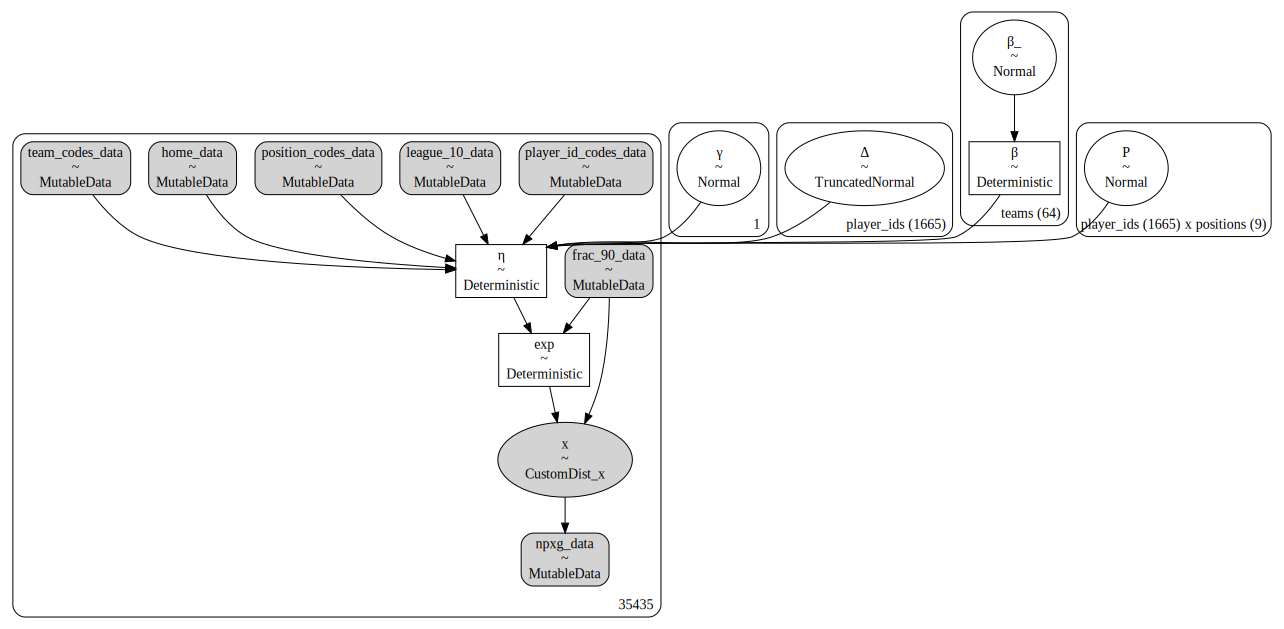

In [15]:
pm.model_to_graphviz(model)

### Prior Predictive

In [16]:
with model:
    prior = pm.sample_prior_predictive(samples=1000)

Sampling: [P, x, Δ, β_, γ]


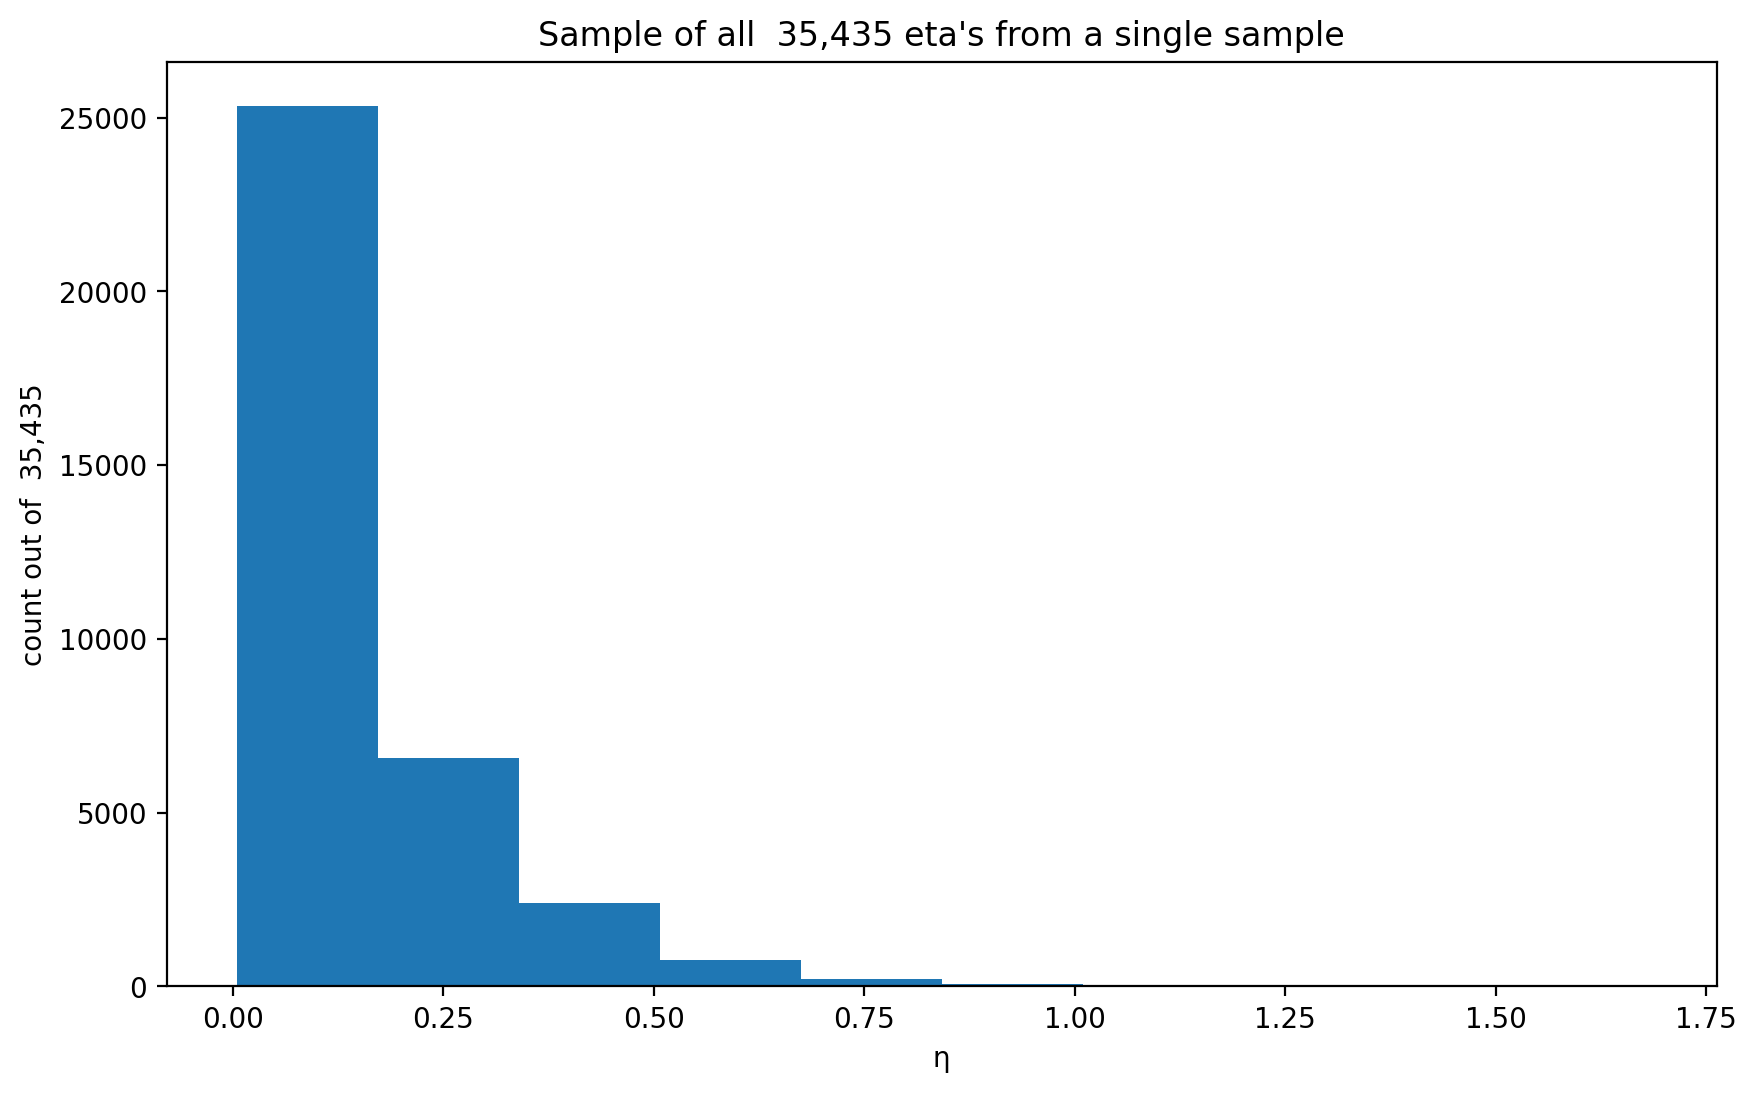

In [17]:
# sample of all eta's form a single sim

plt.hist(prior.prior.η.sel(chain=0, draw=0).data)
plt.title(f"Sample of all {len(df_model): ,} eta's from a single sample")
plt.xlabel("η")
plt.ylabel(f"count out of {len(df_model): ,}");

Vast majority of $\eta$ < 1, which is sensible.

### Sample

In [18]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, Δ, β_, P]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 637 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


### MCMC Diagnostics

R-hat value < 1.1 => Good

In [19]:
az.summary(idata, var_names=["γ", "Δ", "β"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
γ[0]                        0.021  0.012  -0.001    0.045      0.000    0.000   
Δ[003a5c72]                -3.101  0.215  -3.507   -2.702      0.003    0.002   
Δ[007b39a5]                -2.297  0.295  -2.827   -1.745      0.003    0.002   
Δ[008a6e6d]                -2.923  0.335  -3.547   -2.303      0.004    0.003   
Δ[008f854b]                -3.899  0.109  -4.020   -3.704      0.001    0.001   
...                           ...    ...     ...      ...        ...      ...   
β[Watford]                  0.158  0.049   0.064    0.247      0.001    0.000   
β[West Bromwich Albion]    -0.357  0.051  -0.454   -0.264      0.001    0.000   
β[West Ham United]          0.240  0.054   0.137    0.339      0.001    0.000   
β[Wolverhampton Wanderers]  0.026  0.054  -0.081    0.124      0.001    0.001   
β[Wycombe Wanderers]       -0.368  0.050  -0.458   -0.273      0.001    0.000   

                             ess_bulk   ess_tail  r_hat  
γ[0]                        2,710.000  2,712.000  1.000  
Δ[003a5c72]                 6,858.000  2,676.000  1.000  
Δ[007b39a5]                 7,986.000  2,368.000  1.000  
Δ[008a6e6d]                 6,149.000  2,515.000  1.000  
Δ[008f854b]                 4,074.000  2,351.000  1.000  
...                               ...        ...    ...  
β[Watford]                  6,087.000  3,059.000  1.000  
β[West Bromwich Albion]     7,170.000  2,988.000  1.000  
β[West Ham United]          6,769.000  3,364.000  1.000  
β[Wolverhampton Wanderers]  5,735.000  2,930.000  1.000  
β[Wycombe Wanderers]        7,150.000  3,329.000  1.000  

[1730 rows x 9 columns]

array([[<Axes: title={'center': 'γ'}>, <Axes: title={'center': 'γ'}>],
       [<Axes: title={'center': 'Δ'}>, <Axes: title={'center': 'Δ'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>]],
      dtype=object)

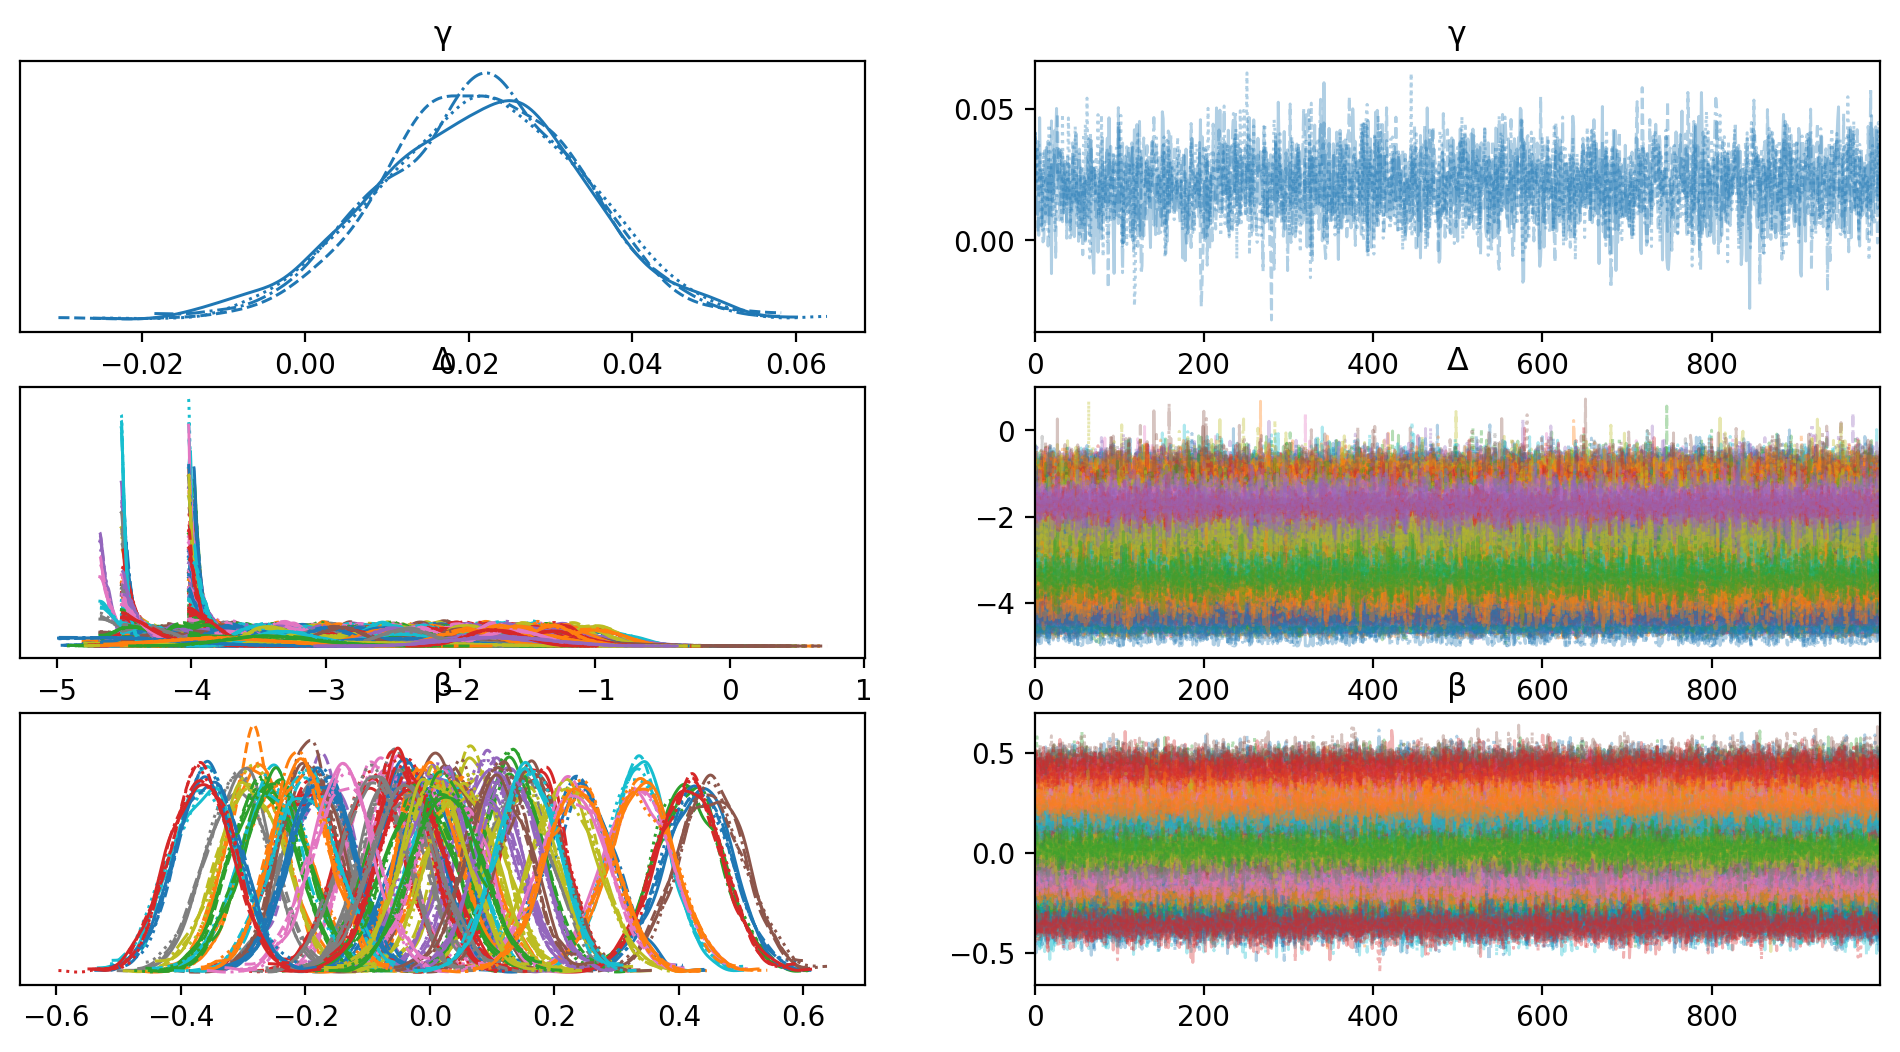

In [20]:
az.plot_trace(idata, var_names=["γ", "Δ", "β"])

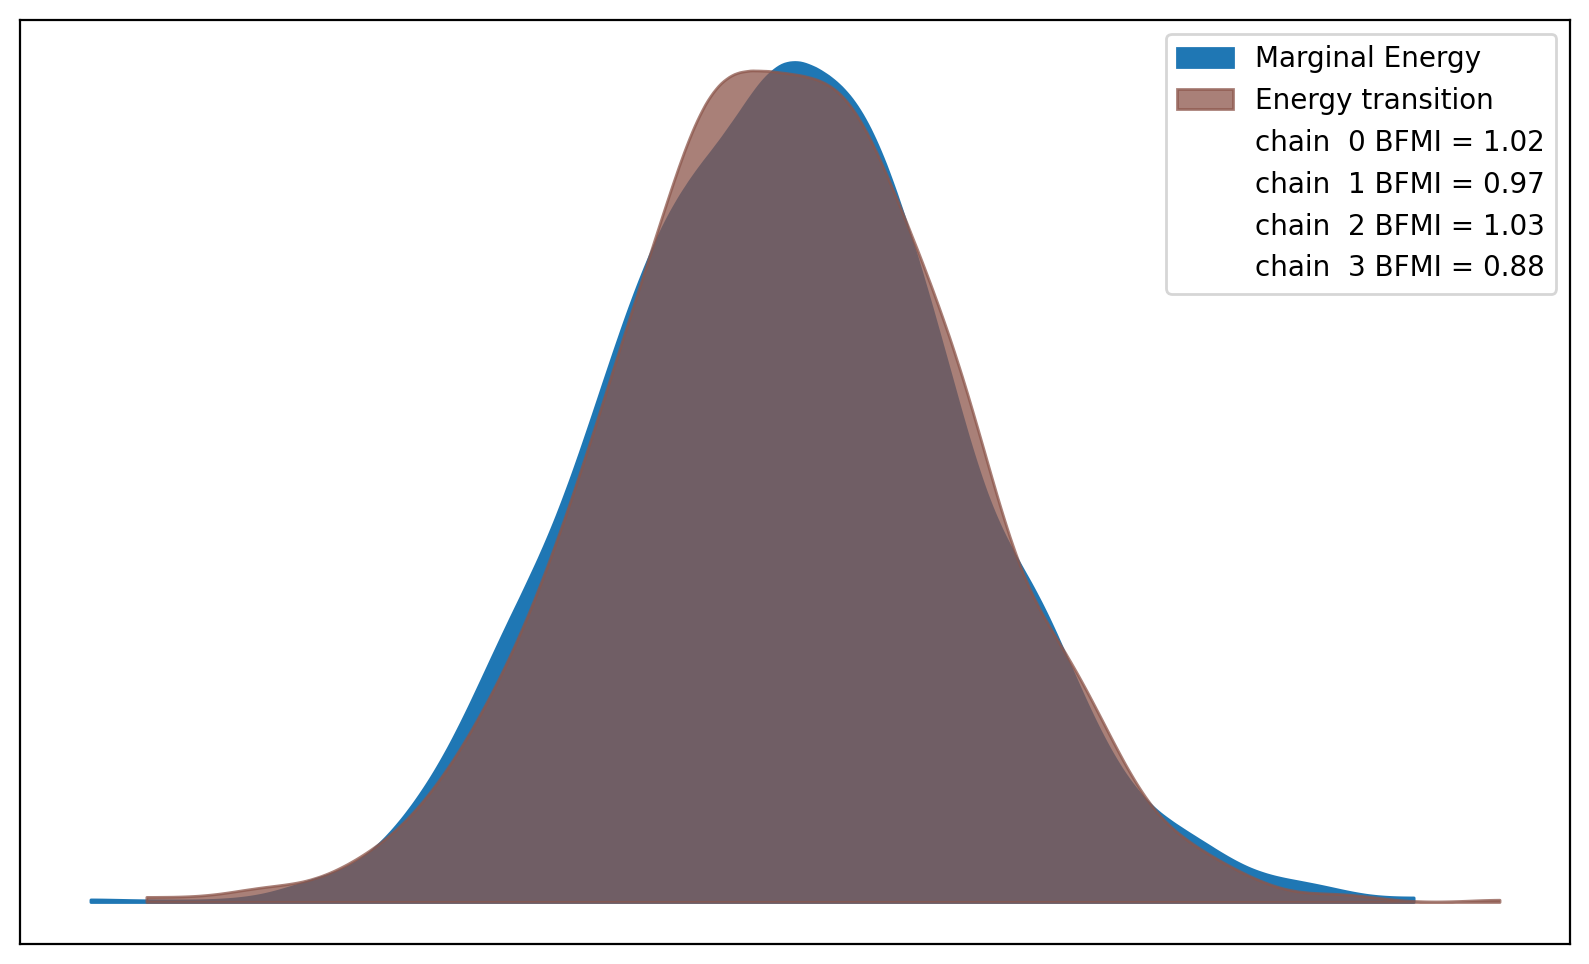

In [21]:
az.plot_energy(idata);

### Model Parameters

In [22]:
az.plot_posterior(idata, var_names=["γ", "Δ", "β"]);

C:\Users\benja\anaconda3\envs\pymc_env_2\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1730) in plot_posterior, generating only 40 plots
  warnings.warn(


In [23]:
# az.plot_forest(idata, var_names=["γ", "Δ", "β"]);

In [24]:
az_summary_Δ = (
    az.
    summary(idata, var_names="Δ")
    .sort_values("mean", ascending=True)
    .assign(
        player_id=lambda x: x.index.str.replace("Δ[", "").str.replace("]", "")
    )
)
az_summary_Δ

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
Δ[242dbdeb] -4.610  0.068  -4.680   -4.486      0.001    0.001  4,588.000   
Δ[983ff2c7] -4.582  0.095  -4.680   -4.413      0.001    0.001  3,775.000   
Δ[ccd1bb4d] -4.515  0.153  -4.680   -4.241      0.002    0.001  4,786.000   
Δ[ebf5f33d] -4.486  0.033  -4.520   -4.424      0.000    0.000  5,177.000   
Δ[282e4e38] -4.470  0.050  -4.520   -4.376      0.001    0.000  3,655.000   
...            ...    ...     ...      ...        ...      ...        ...   
Δ[ac05f970] -1.080  0.179  -1.419   -0.748      0.002    0.002  6,155.000   
Δ[4cde5509] -0.994  0.186  -1.359   -0.657      0.002    0.002  7,005.000   
Δ[dea698d9] -0.992  0.157  -1.280   -0.707      0.002    0.001  8,248.000   
Δ[eb2fe5b6] -0.991  0.197  -1.368   -0.636      0.002    0.002  8,730.000   
Δ[1cadaf34] -0.942  0.227  -1.398   -0.554      0.003    0.002  7,992.000   

              ess_tail  r_hat player_id  
Δ[242dbdeb]  1,916.000  1.000  242dbdeb  
Δ[983ff2c7]  1,915.000  1.000  983ff2c7  
Δ[ccd1bb4d]  2,257.000  1.000  ccd1bb4d  
Δ[ebf5f33d]  2,047.000  1.000  ebf5f33d  
Δ[282e4e38]  1,924.000  1.000  282e4e38  
...                ...    ...       ...  
Δ[ac05f970]  3,109.000  1.000  ac05f970  
Δ[4cde5509]  2,575.000  1.000  4cde5509  
Δ[dea698d9]  2,738.000  1.000  dea698d9  
Δ[eb2fe5b6]  2,853.000  1.000  eb2fe5b6  
Δ[1cadaf34]  2,452.000  1.000  1cadaf34  

[1665 rows x 10 columns]

### Posterior Predictive

In [25]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [x]


In [26]:
df_posterior_predictive = df.copy()
NUM_CHAINS = 4

# add chains to df
df_posterior_predictive_chains = pd.DataFrame(
    [
        [idata.posterior_predictive.sel(chain=c, x_dim_2=r).x.data for c in range(NUM_CHAINS)] 
        for r in range(len(df_posterior_predictive))
    ], columns=[f"pred_npxg_{i}" for i in range(NUM_CHAINS)])
df_posterior_predictive = df_posterior_predictive.join(df_posterior_predictive_chains)

# calculate average of all chains
df_posterior_predictive["pred_npxg"] = 0.0
for i in range(NUM_CHAINS):
    df_posterior_predictive.pred_npxg += np.array(
        [df_posterior_predictive[f"pred_npxg_{i}"][n].mean() for n in range(len(df_posterior_predictive))]
    ) / NUM_CHAINS

In [27]:
# player_ids table
df_posterior_predictive_player_ids = (
    df_posterior_predictive
    .groupby(["player_id"], as_index=False)
    .agg(
        total_minutes=("minutes", sum), 
        total_npxg=("npxg", sum),
        total_pred_npxg=("pred_npxg", sum),
    )
    .assign(
        npxg90=lambda x: (x.total_npxg / x.total_minutes) * 90.0,
        pred_npxg90=lambda x: (x.total_pred_npxg / x.total_minutes) * 90.0,
    )
    .merge(
        az_summary_Δ[["player_id", "mean"]].rename(columns={"mean": "Δ"}),
        how="left",
        on="player_id",
        validate="1:1"
    )
    .assign(eΔ=lambda x: np.exp(x.Δ))
    .sort_values("Δ")
)
df_posterior_predictive_player_ids

player_id  total_minutes  total_npxg  total_pred_npxg  npxg90  \
224   242dbdeb      1,990.000       0.100            0.341   0.005   
996   983ff2c7      1,757.000       0.100            0.211   0.005   
1329  ccd1bb4d        703.000       0.000            0.101   0.000   
1549  ebf5f33d      3,424.000       0.100            0.594   0.003   
244   282e4e38      2,498.000       0.100            0.463   0.004   
...        ...            ...         ...              ...     ...   
1118  ac05f970      1,974.000      13.100           12.765   0.597   
503   4cde5509      1,493.000      11.900            9.869   0.717   
1458  dea698d9      2,802.000      21.700           19.077   0.697   
1541  eb2fe5b6      1,436.000      13.100           10.181   0.821   
179   1cadaf34        703.000       5.600            4.956   0.717   

      pred_npxg90      Δ     eΔ  
224         0.015 -4.610  0.010  
996         0.011 -4.582  0.010  
1329        0.013 -4.515  0.011  
1549        0.016 -4.486  0.011  
244         0.017 -4.470  0.011  
...           ...    ...    ...  
1118        0.582 -1.080  0.340  
503         0.595 -0.994  0.370  
1458        0.613 -0.992  0.371  
1541        0.638 -0.991  0.371  
179         0.634 -0.942  0.390  

[1665 rows x 8 columns]

In [28]:
player_id = "242dbdeb"

df_posterior_predictive_player_ids.query("player_id == @player_id")

player_id  total_minutes  total_npxg  total_pred_npxg  npxg90  \
224  242dbdeb      1,990.000       0.100            0.341   0.005   

     pred_npxg90      Δ     eΔ  
224        0.015 -4.610  0.010

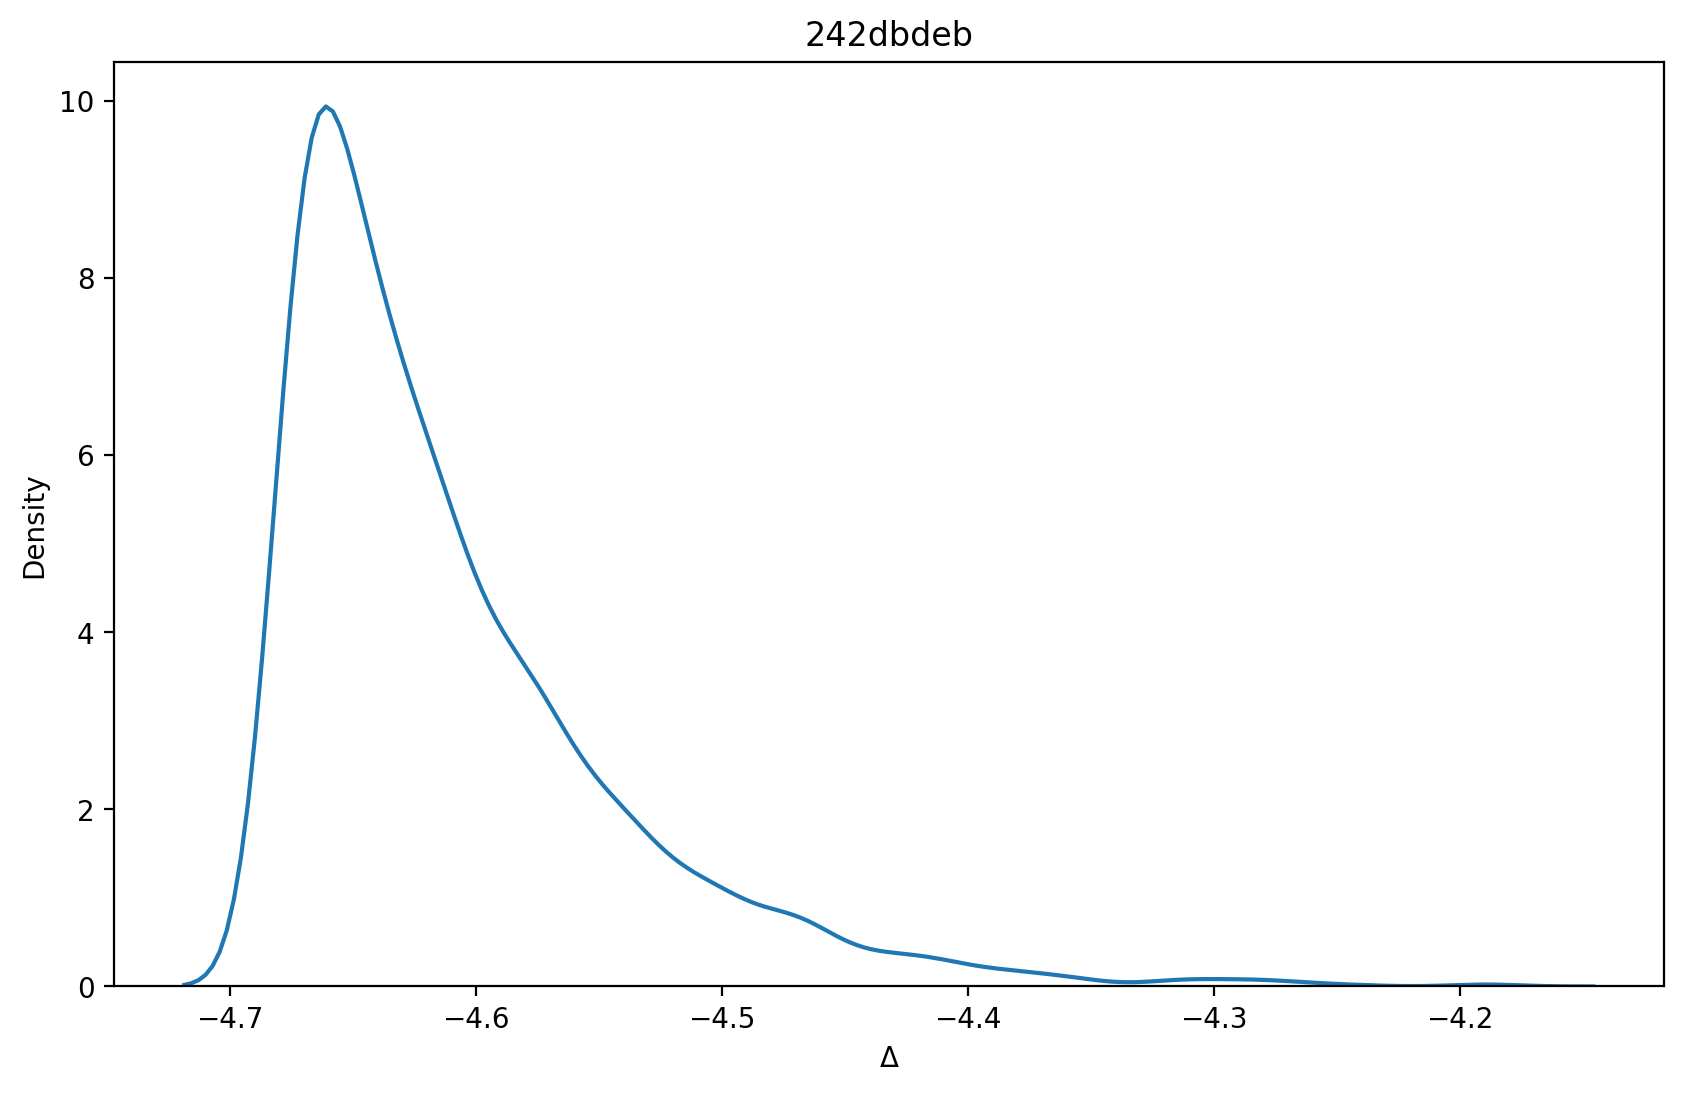

In [29]:
sns.kdeplot(idata.posterior.Δ.sel(player_ids=player_id).data.flatten())
plt.xlabel("Δ")
plt.title(player_id);